In [3]:
import random
from typing import List, Tuple, Iterable

from IPython.display import display, clear_output
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [48]:
SAMPLE_SIZE = 10
BOARD_SIZE = 10
ITERATIONS = 20000
MUTATION_PROBABILITY = 0.15


def init_population(sample_size: int=SAMPLE_SIZE, board_size: int=BOARD_SIZE) -> List:
    """initializes population of given size.
    
    
    params:
    
    sample_size int: number of individuals in initialized sample (should be //2)
    
    board_size int: shape of the chessboard
    
    returns:
    
    population List: list of np.arrays where every array represents individual
    in the population of declared size.
    
    """
    population = [np.random.randint(1, board_size+1, board_size) for _ in range(sample_size)]
    return population


def make_coordinates(individual_dna: Iterable[int]) -> List:
    """converts list to x, y coordinates
    
    params:
    
    individual_dna Iterable: iterable object representing dna of one individual.
    
    returns:
    
    cooridnates List: list of tuples representing x and y coordinates of given
    ividual dna on the chessboard
    
    """
    coordinates = []
    for col, row in enumerate(individual_dna):
        pos = (row, col+1)
        coordinates.append(pos)
    return coordinates


def calculate_score(individual_dna: Iterable[int]) -> float:
    """calculates score for given individual
    
    params:
    
    individual_dna Iterable: iterable object representing dna of one individual.    
    
    returns:
    
    score float: 1/(colisions +1)
    
    """
    coordinates = make_coordinates(individual_dna)
    colisions = 0
    for idx_1, pos_1 in enumerate(coordinates):
        for idx_2, pos_2 in enumerate(coordinates):
            if idx_1 == idx_2: # skip counting colisions for object itself
                pass
            else:
                if (pos_2[0]-pos_1[0] == pos_2[1]-pos_1[1]): #diagonal
                    colisions += 1
                if (pos_2[0]-pos_1[0] == pos_1[1]-pos_2[1]): #diagonal
                    colisions += 1
                if (pos_1[0] == pos_2[0]): # in one col
                    colisions += 1
                if (pos_1[1] == pos_2[1]): # in one row
                    colisions += 1
                else: pass
    return 1/(colisions + 1)


def calculate_scores(population: List) -> List:
    """calculate scores for whole population
    
    params:
    
    population List: list of np.arrays where every array represents individual
    in the population of declared size.
    
    returns:
    
    scores: list containing scores for whole population
    
    """
    scores = []
    for dna in population:
        scores.append(calculate_score(dna))
    return scores


def calculate_cross_probs(scores: List) -> List:
    """calculate probabilities for the whole population of being choosen
    for repoduction in next step
    
    params:
    
    scores List: list containing scores for whole population
       
    returns:
    
    probs List: list containing probabilities of being choosen for reporoduction
    calculated based on the score - the higher the score, the greater the prob
    
    """
    probs = [score/sum(scores) for score in scores]
    return probs


def make_crossover(population: List, probs: List) -> Tuple[Iterable, Iterable]:
    """make two crossovers of two choosen individals based on probabilities
    
    params:
    
    population List: list of np.arrays where every array represents individual
    in the population of declared size.
    
    probs List: list containing probabilities of being choosen for reporoduction
    calculated based on the score
    
    returns:
    
    crossover_1, crossover_2 Tuple: tuple containg two child of randomly selected
    parents according to probabilities  
    
    """
    idx_1, idx_2 = 0, 0
    while (idx_1==idx_2):
        idx_1, idx_2 = random.choices(population=range(SAMPLE_SIZE),
                                      weights=probs,
                                      k=2)
    crossover_1, crossover_2 = population[idx_1].copy(), population[idx_2].copy()      

    crossover_point = random.randrange(0, BOARD_SIZE) 
    crossover_1[crossover_point:] = population[idx_2][crossover_point:]
    crossover_2[crossover_point:] = population[idx_1][crossover_point:]

    return crossover_1, crossover_2


def make_mutation(population: List,
                  mutation_probability: float=MUTATION_PROBABILITY) -> List:
    """make mutation with given probability
    
    params:
    
    population List: list of np.arrays where every array represents individual
    in the population of declared size.
    
    mutation_probability float: probability of mutation of individual 
    
    returns:
    
    population List: list of np.arrays where every array represents individual
    in the population of declared size after random mutation.   
    
    """
    population_c = [dna.copy() for dna in population]
    for dna in population_c:
        if random.random() < mutation_probability:
            dna[random.randrange(BOARD_SIZE)] = np.random.randint(0, BOARD_SIZE+1)
        else:
            pass
    return population_c


def generation_survival(population : List) -> Tuple[List, float, List, float]:
    """Reproduction of population and killing the worst performing idividuals
    to mantain input size (half of the population is getting killed)
    
    params: 
    
    population List: list of np.arrays where every array represents individual
    in the population of declared size.
    
    returns:
    
    population List: list of np.arrays where every array represents individual
    in the population of declared size. Newly calculated one after reproduction,
    selection and mutation.
    
    max_score float: The best score in given population
    
    best_dna np.array: array containing best dna from the population
    (with the highest score)    
    
    avg_score float: average score for given population
    
    """
    scores = calculate_scores(population)
    probs = calculate_cross_probs(scores)

    for i in range(int(len(population)/2)):
        pairs = make_crossover(population, probs)
        population.extend([x for x in pairs])
        
    population = make_mutation(population)
    scores = calculate_scores(population)
    #sort population based on the scores
    pop_sorted, _ = zip(*sorted(zip(population, scores),
                                key=lambda x: x[1],
                                reverse=True))

    population = pop_sorted[:int(len(population)/2)]
    population = [ele for ele in population]
    max_score = max(scores)
    avg_score = sum(scores)/len(scores)
    best_dna = population[0]
    return population, max_score, best_dna, avg_score


def plot_solution(solution: Iterable):
    """plot chessboard with inputed solution
    
    params:
    
    solution Iterable: iterable containing dna of solution that will be plotted
    
    """
    xs, ys = [], []
    for x, y in enumerate(solution):
        xs.append(x+0.5)
        ys.append(y-0.5)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(xs, ys, marker='X', s =150, c = 'k')
    major_ticks = range(0, BOARD_SIZE+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.grid(which='major')
    ax.set_title(f'Solution for {BOARD_SIZE}x{BOARD_SIZE} board')
    plt.show()


def plot_training(max_scores, avg_scores):
    """plot training scores: max and avg for every epoch
    
    params:
    
    max_scores Iterable: iterable containing max scores for all training epochs
    
    avg_scores Iterable: iterable containing avg scores for all training epochs   
    
    """
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot()     
    x = range(0, len(max_scores))
    y1 = max_scores
    y2 = avg_scores
    ax.cla()
    plt.plot(x, y1, label = 'max score for given epoch')
    plt.plot(x, y2, label = 'avg score for given epoch')
    ax.set_xlim(0, len(max_scores))    
    ax.set_ylim(0, 1.0)
    plt.legend(loc = 'upper left')
    plt.title('Training process')
    plt.show()     
    
    
def evolution(epochs: int = ITERATIONS):
    """training function
    
    params:
    
    epochs int: number of epochs
    
    returns:
    
    best_dna np.array: array containing best dna from the population
    (with the highest score)    
    
    max_score float: The best score in given population
    
    avg_score float: average score for given population    

    population List: list of np.arrays where every array represents individual
    in the population of declared size. Newly calculated one after reproduction,
    selection and mutation.  
    
    """
    population = init_population(SAMPLE_SIZE, BOARD_SIZE)
    max_scores = []
    avg_scores = []
    best_dna = None
    for it in range(1, epochs+1):
        population, max_score, best_dna, avg_score = generation_survival(population)
        
        max_scores.append(max_score)
        avg_scores.append(avg_score)

        if max_score == 1.0:
            print(f'Solution found on iteration: {it}. Solution: {best_dna}')
            break
        if it == epochs:
            print('Solution not found')
    return best_dna, max_scores, avg_scores, population

Solution found on iteration: 73. Solution: [ 5 10  8  1  3  9  7  2  0  6]


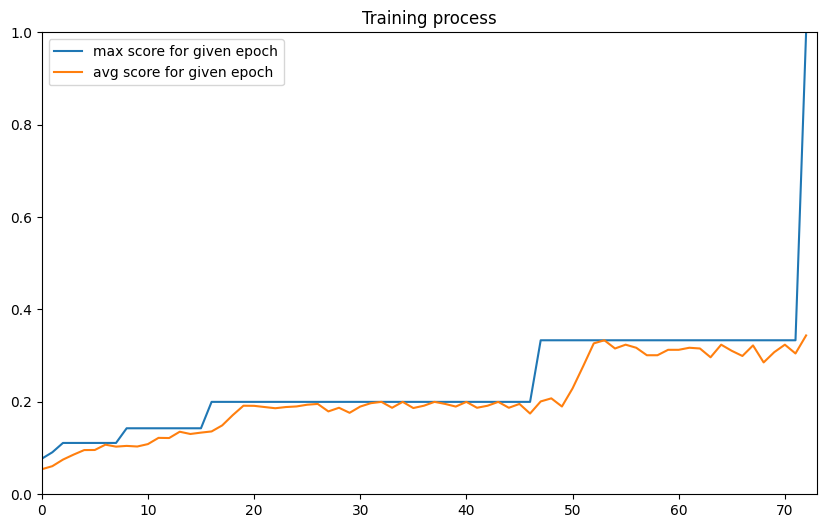

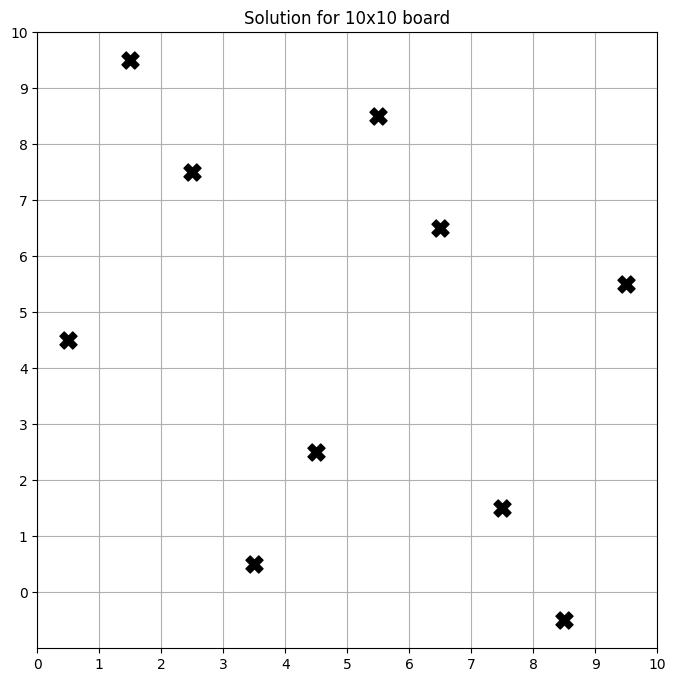

In [54]:
population = init_population(SAMPLE_SIZE, BOARD_SIZE)
best_dna, max_scores, avg_scores, end_population = evolution(ITERATIONS)
plot_training(max_scores, avg_scores)
plot_solution(best_dna)

In [55]:
end_population

[array([ 5, 10,  8,  1,  3,  9,  7,  2,  0,  6]),
 array([ 2, 10,  8,  1,  3,  9,  7, 10,  0,  6]),
 array([ 2, 10,  8,  1,  3,  9,  7, 10,  0,  6]),
 array([ 2, 10,  8,  1,  3,  9,  7, 10,  0,  6]),
 array([ 2, 10,  8,  1,  3,  9,  7, 10,  0,  6]),
 array([ 2, 10,  8,  1,  3,  9,  7,  5,  0,  6]),
 array([ 2, 10,  8,  1,  3,  9,  7, 10,  0,  6]),
 array([ 2, 10,  8,  1,  3,  9,  7, 10,  0,  6]),
 array([ 2, 10,  8,  1,  3,  9,  7, 10,  0,  6]),
 array([ 2, 10,  8,  1,  3,  9,  7, 10,  0,  6])]

# Benchmark

In [ ]:
res_random = []
for _ in tqdm(range(100)):
    max_score = 0
    it = 0
    while max_score < 1.0:
        dna = init_population(SAMPLE_SIZE)
        scores = calculate_scores(dna)
        max_score = max(scores)
        it+=1
    res_random.append(it)

In [27]:
res_random

[540305,
 307413,
 1335655,
 179602,
 2055802,
 875397,
 129972,
 2842771,
 591731,
 662867,
 705342,
 943507,
 1008800,
 81578,
 2514775,
 5831993,
 772810,
 108457,
 1398084,
 1421793,
 299644,
 644841,
 162160,
 1371424,
 1128745,
 1225155,
 522463,
 1677761,
 1900612,
 2972784,
 1460177,
 19060,
 555709,
 864762,
 8854879]

In [29]:
res_genetic = []
for _ in range(35):
    dna = init_population(SAMPLE_SIZE)
    scores = calculate_scores(dna)
    _, max_scores, _, _ = evolution()
    res_genetic.append(len(max_scores))    

Solution found on iteration: 576. Solution: [ 6  9  2 10  8  3  1  4  7  5]
Solution found on iteration: 413. Solution: [ 2  6  3 10  8  5  9  4  1  7]
Solution not found
Solution found on iteration: 26065. Solution: [ 3  5  9  2 10  7  4  1  8  6]
Solution found on iteration: 3737. Solution: [10  8  2  4  1  7  9  6  3  5]
Solution found on iteration: 8631. Solution: [ 7  4  8  1  5  9  2  6 10  3]
Solution found on iteration: 290. Solution: [ 2  9  7 10  4  1  5  8  6  3]
Solution found on iteration: 131. Solution: [ 7  5  2  8  1  4  9  3  6 10]
Solution found on iteration: 272. Solution: [ 1  4 10  7  9  3  5  2  8  6]
Solution not found
Solution found on iteration: 28882. Solution: [ 7  5  1  6  9  3  8  4  2 10]
Solution found on iteration: 18300. Solution: [ 6  2  9  1  8  5  3 10  7  4]
Solution found on iteration: 3143. Solution: [ 2 10  8  3  5  9  1  6  4  7]
Solution found on iteration: 221. Solution: [10  5  7  2  4  8  1  9  6  3]
Solution found on iteration: 4053. Soluti

In [30]:
epoch_res = pd.DataFrame({'random search' : res_random,
                          'genentic algorithm' : res_genetic})

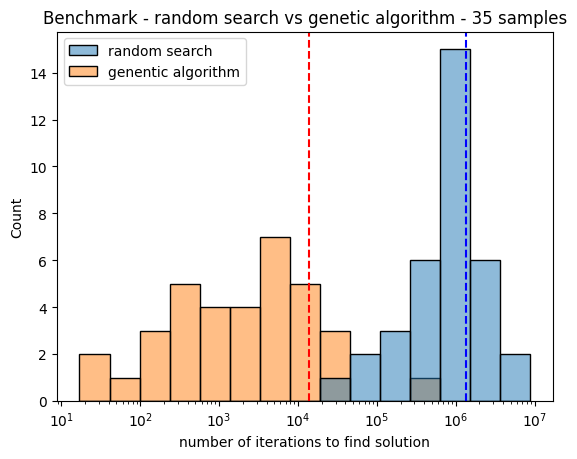

In [45]:
mean_random = sum(res_random)/len(res_random)
mean_genetic = sum(res_genetic)/len(res_genetic)
graph = sns.histplot(data = epoch_res, common_norm=True,
                     common_bins=True, bins = 15,
                     log_scale=True)
graph.axvline(mean_genetic, c = 'red', linestyle = '--')
graph.axvline(mean_random, c = 'blue', linestyle = '--')
plt.title('Benchmark - random search vs genetic algorithm - 35 samples')
plt.xlabel('number of iterations to find solution')
plt.show()